# Returns Drivers

In [1]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

from   DataCollect import BoxSpreadData

In [2]:
def get_strategy(name: str) -> pd.DataFrame: 
    
    data_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data")
    model_path = os.path.join(data_path, "Model1")
    tmp_path = os.path.join(model_path, name + ".parquet")
    
    df_out = pd.read_parquet(path = tmp_path, engine = "pyarrow")
    return df_out

df_erc = get_strategy("EqualRiskContribution")
df_max_sharpe = get_strategy("MaxSharpe")
df_signal = get_strategy("RawSignals")

In [3]:
def get_treasury_liquidty() -> pd.DataFrame: 
    
    df_out = (BoxSpreadData().get_tsy_liquidity().drop(
        columns = ["security"]).
        sort_values("date").
        set_index("date").
        rename(columns = {"value": "PX_LIQUIDITY"}).
        assign(
            PX_LIQUIDITY_LAG     = lambda x: x.PX_LIQUIDITY.shift(),
            PX_LIQUIDITY_PCT     = lambda x: x.PX_LIQUIDITY.pct_change(),
            PX_LIQUIDITY_PCT_LAG = lambda x: x.PX_LIQUIDITY_PCT.shift()))
    
    return df_out

df_liquidity = get_treasury_liquidty()

In [4]:
def _get_regression(df: pd.DataFrame, strat: str, endogenous_variable: str, ax) -> None: 
    
    model = (sm.OLS(
        endog = df.signal_rtn,
        exog  = sm.add_constant(df[endogenous_variable])).
        fit())
    
    alpha, beta = model.params
    rsquared = model.rsquared
    
    x = np.linspace(
        start = df[endogenous_variable].min(), 
        stop  = df[endogenous_variable].max(), 
        num   = 1_000)
    
    y = (x * beta) + alpha    
    
    ax.plot(x, y, color = "red")
    ax.set_title("{}\n Alpha: {} Beta: {} R2: {}%".format(
        strat,
        round(alpha, 2),
        round(beta, 2),
        round(rsquared * 100, 2)))
    
def plot_liquidity_change_regression(
    df_signal: pd.DataFrame, 
    df_liquidity: pd.DataFrame,
    endogenous_variable: str) -> plt.Figure: 

    df_combined = (df_signal.query(
        "variable == 'PX_BPS'")
        [["date", "strat", "signal_rtn"]].
        merge(right = df_liquidity, how = "inner", on = ["date"]).
        dropna()
        [["date", "strat", "signal_rtn", endogenous_variable]])

    strats = df_combined.strat.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(strats) // 3, nrows = len(strats) // 6, figsize = (30,15))

    for strat, ax in zip(strats, axes.flatten()): 

        df_plot = (df_combined.query(
            "strat == @strat"))

        (df_plot.plot(
            ax     = ax,
            kind   = "scatter",
            x      = endogenous_variable,
            y      = "signal_rtn",
            alpha  = 0.7,
            ylabel = "Signal Return (Bps)"))

        _get_regression(df_plot, strat, endogenous_variable, ax)
        
        
        if endogenous_variable.split("_")[-2] == "PCT": ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))

    fig.suptitle("Comparison of % Change of Govt Liquidity Securities vs. Treasury Signals\nFrom {} to {}".format(
        df_combined.date.min(),
        df_combined.date.max()))
    plt.tight_layout()

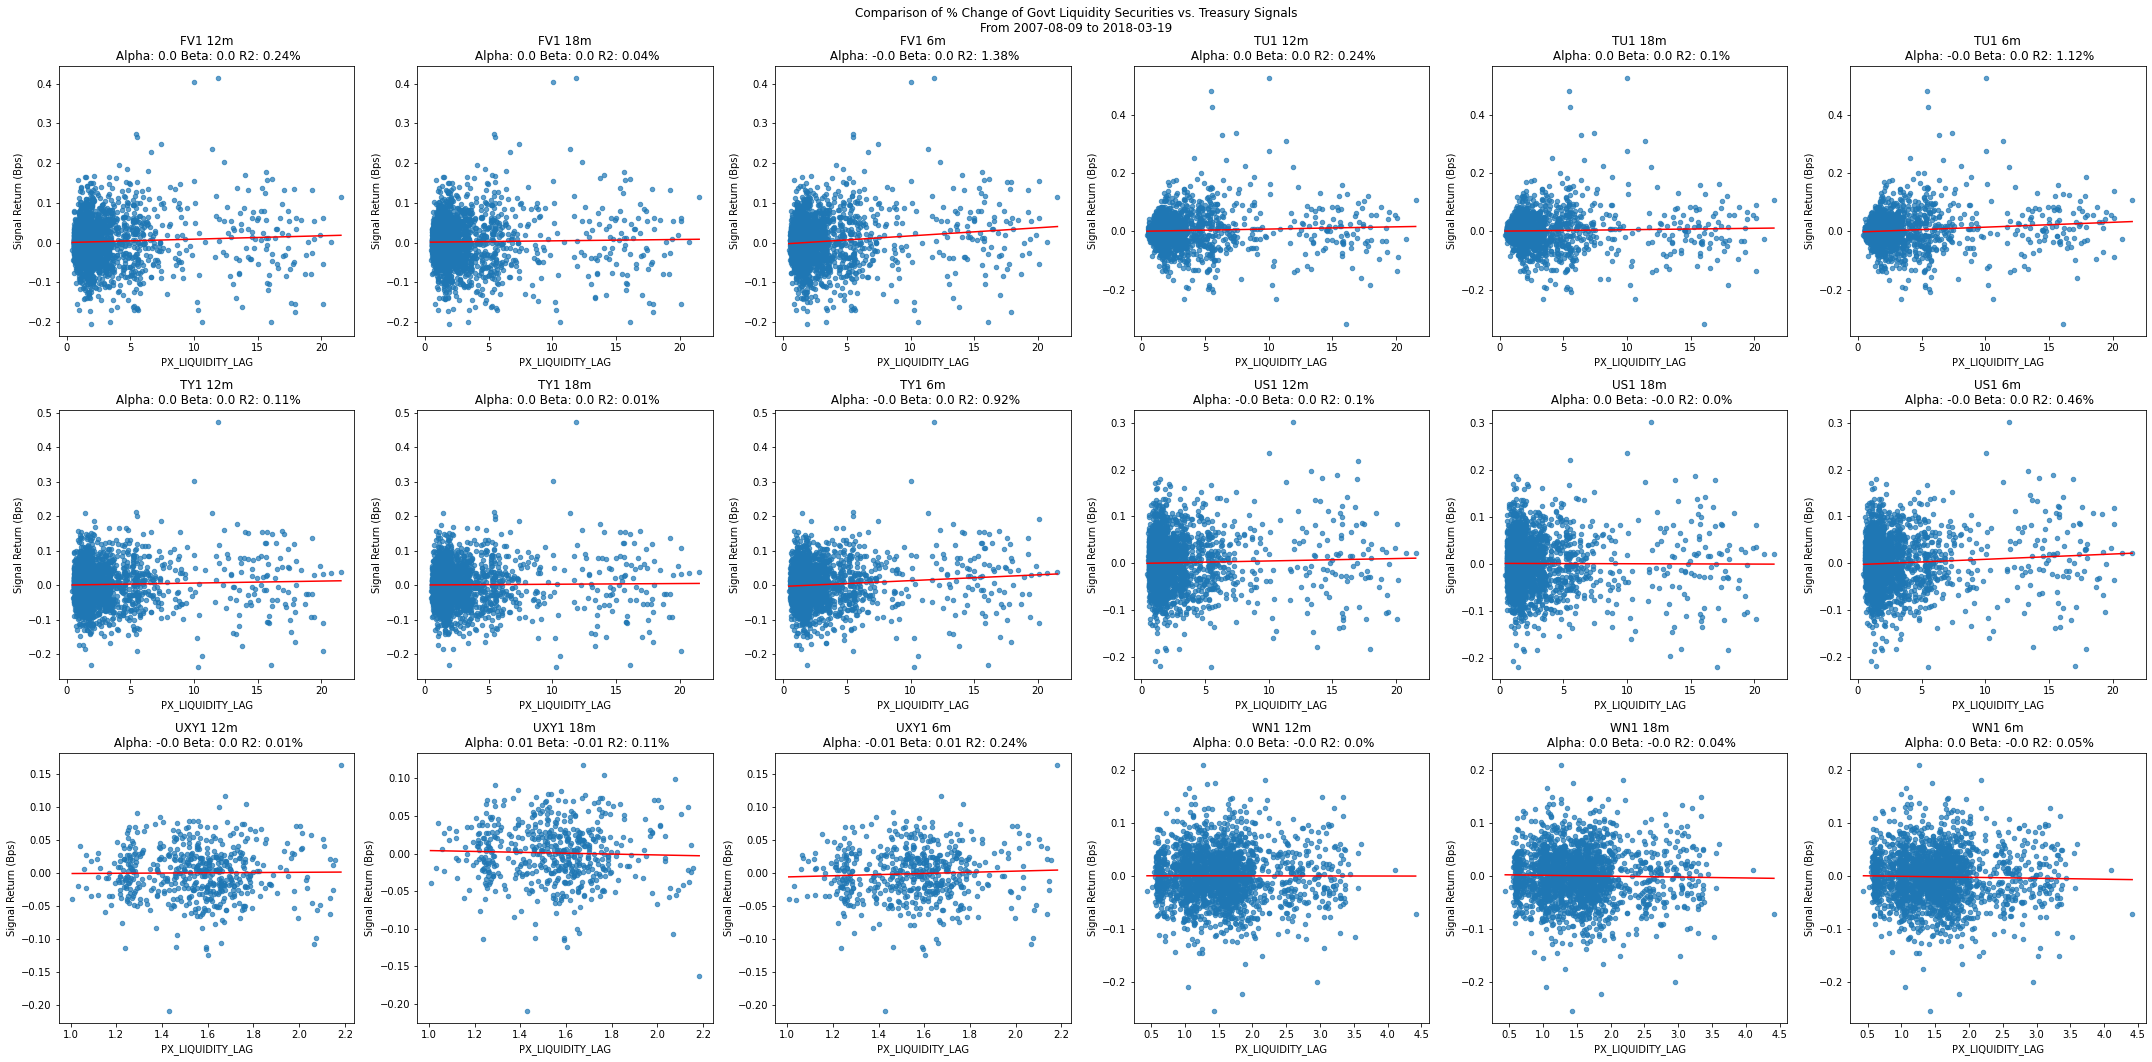

In [5]:
plot_liquidity_change_regression(df_signal, df_liquidity, "PX_LIQUIDITY_LAG")

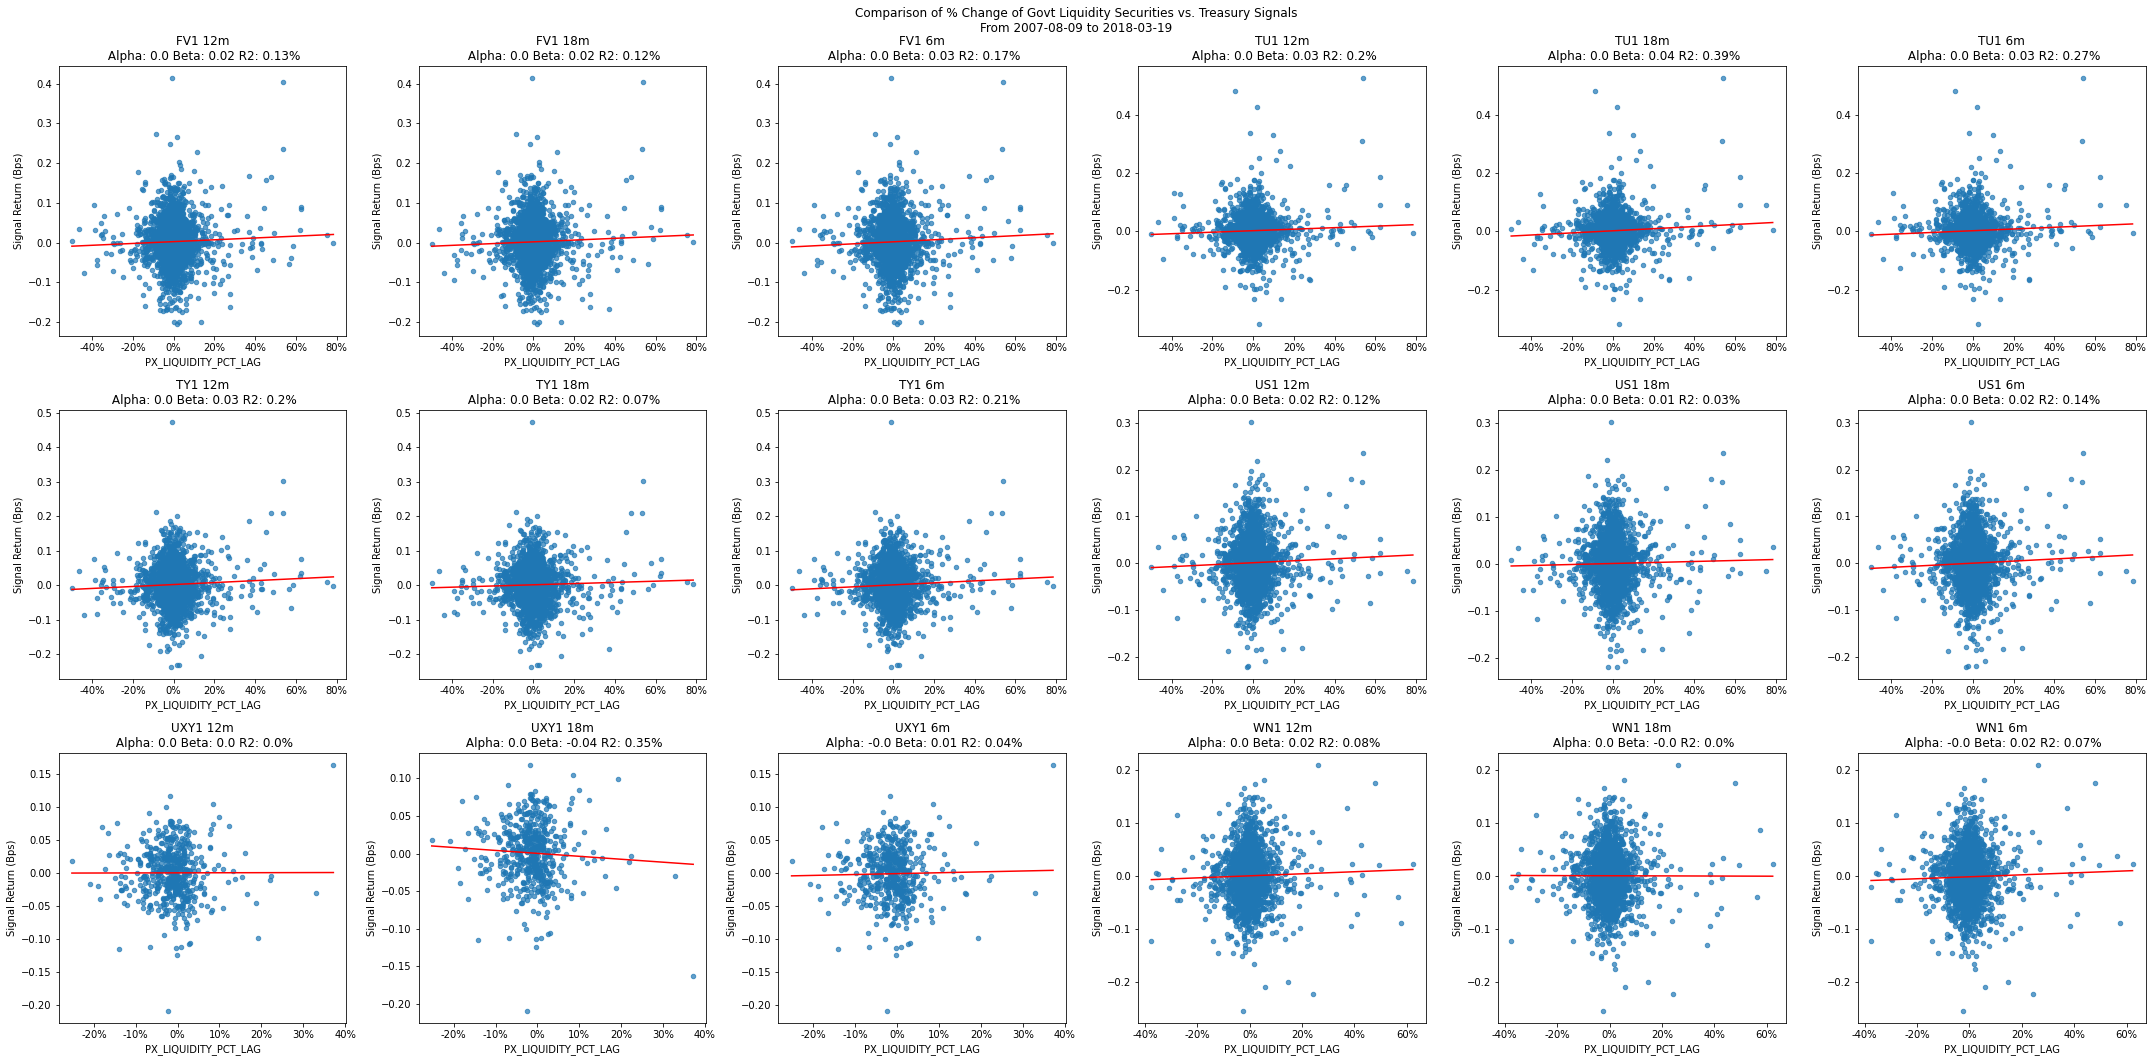

In [6]:
plot_liquidity_change_regression(df_signal, df_liquidity, "PX_LIQUIDITY_PCT_LAG")